In [1]:
'''
Find the price correlated HK stocks in same sector for Pair strategy 
Buy the stock when it is relatively under-priced to the correlated stock 
and sell the corresponding over-priced stock
As they're price correlated (statistically), assume they will go back to the similar price ratio later (mean reversion)
Hence (hopefully), the under-priced stock (bought) will goes up later while the over-priced (sold) one will drop

Pair strategy is a type of relative value strategies or statistical arbitrage 
which rely on the mean-reversion of prices to the asset's fair value. 
They assume that prices only temporarily move away from fair value due to behavioral effects 
like overreaction or herding, or liquidity effects such as temporary market impact or long-term supply/demand friction. 
'''

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')

# Google colab interactive table
%load_ext google.colab.data_table 
%matplotlib inline

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()


# Display the stock info in Chinese or not
def useChinese(use=True):
  # return COL_NAME, COL_INDUSTRY, COL_SECTOR, AJD_CLOSE_FILE
  if use:
    return 'nameChi', 'industryChi', 'sectorChi', 'hkStocksAdjClosePxChi.csv'

  else:
    return 'shortName', 'industry', 'sector', 'hkStocksAdjClosePx.csv'


COL_NAME, COL_INDUSTRY, COL_SECTOR, AJD_CLOSE_FILE = useChinese(False)

--2021-02-23 12:21:10--  https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf [following]
--2021-02-23 12:21:10--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘simhei.ttf.1’

simhei.ttf.1        100%[===================>]   9.30M  29.6MB/s    in 0.3s    

2021-02-23 12:21:10 (29.6 MB/s) - ‘simhei.ttf.1’ saved [9751960/9751960]



In [2]:
# Get the stock information from Yahoo
stockInfo = web.get_quote_yahoo(['0700.HK', '0005.HK', '0939.HK'])
stockInfo

language region quoteType  ...     market  esgPopulated   price
0700.HK    en-US     US    EQUITY  ...  hk_market         False  707.00
0005.HK    en-US     US    EQUITY  ...  hk_market         False   46.70
0939.HK    en-US     US    EQUITY  ...  hk_market         False    6.37

[3 rows x 66 columns]

In [3]:
# show the column names
stockInfo.columns

Index(['language', 'region', 'quoteType', 'quoteSourceName', 'triggerable',
       'currency', 'regularMarketChange', 'regularMarketChangePercent',
       'regularMarketTime', 'regularMarketPrice', 'regularMarketDayHigh',
       'regularMarketDayRange', 'regularMarketDayLow', 'regularMarketVolume',
       'regularMarketPreviousClose', 'bid', 'ask', 'bidSize', 'askSize',
       'fullExchangeName', 'financialCurrency', 'regularMarketOpen',
       'averageDailyVolume3Month', 'averageDailyVolume10Day',
       'fiftyTwoWeekLowChange', 'fiftyTwoWeekLowChangePercent',
       'fiftyTwoWeekRange', 'fiftyTwoWeekHighChange',
       'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh',
       'earningsTimestamp', 'earningsTimestampStart', 'earningsTimestampEnd',
       'trailingAnnualDividendRate', 'trailingPE',
       'trailingAnnualDividendYield', 'epsTrailingTwelveMonths', 'epsForward',
       'sharesOutstanding', 'bookValue', 'fiftyDayAverage',
       'fiftyDayAverageChange',

In [4]:
# Get the pre-downloaded all HK stocks information from yahoo
# Source the Chinese name and stock sectors from http://www1.hket.com/finance/chart/industry-index.do

# Pandas support reading Excel directly
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
stocksInfo

code        shortName   nameChi  ... epsForward  forwardPE dividendDate
0      4333.HK          CISCO-T      思科系統  ...        NaN        NaN          NaN
1      4335.HK          INTEL-T       英特爾  ...        NaN        NaN          NaN
2      4338.HK      MICROSOFT-T        微軟  ...        NaN        NaN          NaN
3      9988.HK          BABA-SW   阿里巴巴-SW  ...        NaN        NaN          NaN
4      0700.HK          TENCENT      騰訊控股  ...      10.94  50.091408          NaN
...        ...              ...       ...  ...        ...        ...          ...
2731  83186.HK  CICCKRANECNET-R  中金金瑞中網-R  ...        NaN        NaN          NaN
2732  83188.HK     CAM CSI300-R  華夏滬深三百-R  ...        NaN        NaN          NaN
2733  83197.HK  CAM MSCI AINC-R  華夏A國際通-R  ...        NaN        NaN          NaN
2734  83199.HK  CSOP CTPBBOND-R  南方政銀國債-R  ...        NaN        NaN          NaN
2735  87001.HK    HUI XIAN REIT    匯賢產業信託  ...       0.22   8.636364          NaN

[2736 rows x 73 columns]

In [5]:
# Look at one stock
CODE = '0005.HK'
stocksInfo[(stocksInfo.code == CODE)]

code      shortName nameChi  ... epsForward forwardPE dividendDate
10  0005.HK  HSBC HOLDINGS    滙豐控股  ...       0.67  52.46269          NaN

[1 rows x 73 columns]

In [6]:
#@title Display in Chinese or not (** Needs to run this block after changes)
USE_CHINESE = True #@param {type:"boolean"}

COL_NAME, COL_INDUSTRY, COL_SECTOR, AJD_CLOSE_FILE = useChinese(USE_CHINESE)

In [7]:
# list the unique industries names
industryNames = stocksInfo[COL_INDUSTRY].unique()
print('Count:', len(industryNames))
print(industryNames)

Count: 23
['資訊科技' '金融' '電訊' '能源' '飲食相關' '地產建築' '傳理' '醫藥' '博彩' '運輸、物流及基建' '消費品製造'
 '綜合企業' '零售' '電力' '汽車生產及分銷' '工業' '環保' '消費者服務業' '工業製品' '原材料' '指數槓桿產品' '基金'
 'ETF']


In [8]:
# list the unique sector names
sectorNames = stocksInfo[COL_SECTOR].unique()
print('Count:', len(sectorNames))
print(sectorNames)

Count: 123
['電訊設備' '半導體' '科技軟件' '電子商貿及互聯網' '網遊及手遊' '國有內銀' '中資電訊' '國際保險' '銀行' '內地保險'
 '其他金融服務' '石油及天然氣' '酒類飲品' '地產發展' '媒體娛樂及文化出版' '醫藥股' '內房' '澳門博彩' '公共運輸' '玩具'
 '綜合企業' '生物科技' '體育用品' '燃氣公用' '餐飲' '電力公用' '超市股' '中小內銀' '汽車' '手機相關' '機械設備'
 '乳品相關' '紡織製衣' '醫療保健' '物業管理及代理' '汽車銷售' '基建' '農漁業產品' '食物飲品生產及批發' '本地電訊'
 '地產投資' '水務公用' '珠寶鐘錶' '休閒食品' '水泥' '家電' '服飾配件' '光伏太陽能' '包裝食品' '節能環保' '服裝零售'
 '投資及資產管理' '電腦及周邊產品' '地產' '建材' '玻璃股' '鋼鐵鋁材' '煤業相關' '中資證券及融資' '有色金屬及礦石'
 '支援服務' '紙業股' '石油燃氣設備及支援' '證券及融資' '博彩相關' '航空服務' '汽車零部件及維護' '飲品股' '家品'
 '港口及服務' '旅遊酒店' '衛星航天股' '影視娛樂' '倉儲物流及運輸' '貴金屬' '非銀行融資' '智能卡及資訊科技器材' '廣告'
 '建築相關' '航運' '電池股' '鞋履' '化妝美容' '電訊服務' '電力設備' '殯儀' '風電股' '鐵路相關' '商業用車及貨車'
 '百貨股' '系統及資料科技顧問' '電子消費品' '公路股' '化工' '替代能源' '新材料' '印刷及包裝' '造船相關' '工業製品'
 '男士服裝' '樓宇建造' '光纖' '化肥農藥' '指數槓桿產品' '彩票股' '支付相關' '林木業' '電子元件' '核電' '基金'
 'LED' '進出口貿易' '房託' '股票 - 中國' '股票 - 香港' '股票 - 亞洲(日本除外)' '債券' '股票 - 環球'
 '股票 - 新興市場' '商品' '貨幣' '股票- 大中華' nan]


In [9]:
# Exploring the data 
# Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', COL_NAME, COL_INDUSTRY, COL_SECTOR, 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False)

code quoteType  ... regularMarketPreviousClose averageDailyVolume10Day
2      4338.HK    EQUITY  ...                     500.00                     0.0
3      9988.HK    EQUITY  ...                     244.80              25690873.0
4      0700.HK    EQUITY  ...                     535.00              20457768.0
14     1398.HK    EQUITY  ...                       4.65             161543498.0
11     2318.HK    EQUITY  ...                      82.65              31290439.0
...        ...       ...  ...                        ...                     ...
2730  83170.HK    EQUITY  ...                      88.02                     NaN
2731  83186.HK    EQUITY  ...                      79.14                     NaN
2732  83188.HK    EQUITY  ...                      47.30                661361.0
2733  83197.HK    EQUITY  ...                      11.32                 10550.0
2734  83199.HK    EQUITY  ...                     102.90                   892.0

[2736 rows x 8 columns]

In [10]:
# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 100000000  # 100 millions
SELECTED_COLUMNS = ['code', COL_NAME, COL_INDUSTRY, COL_SECTOR, 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER)].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

code  nameChi industryChi sectorChi      turnover
1    0700.HK     騰訊控股        資訊科技     網遊及手遊  1.094491e+10
0    9988.HK  阿里巴巴-SW        資訊科技  電子商貿及互聯網  6.289126e+09
27   0981.HK     中芯國際        資訊科技       半導體  5.881712e+09
3    3690.HK   美團點評-W        資訊科技  電子商貿及互聯網  4.727324e+09
8    0388.HK    香港交易所          金融    其他金融服務  2.732908e+09
..       ...      ...         ...       ...           ...
141  0136.HK     恒騰網絡          能源     光伏太陽能  1.084515e+08
92   0880.HK     澳博控股          博彩      澳門博彩  1.077015e+08
159  3606.HK     福耀玻璃     汽車生產及分銷  汽車零部件及維護  1.056159e+08
153  3933.HK     聯邦制藥          醫藥       醫藥股  1.038379e+08
121  1268.HK     美東汽車     汽車生產及分銷      汽車銷售  1.035112e+08

[180 rows x 5 columns]

In [11]:
# Industry Distribution with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[[COL_INDUSTRY, 'code']].groupby([COL_INDUSTRY]).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[[COL_INDUSTRY, COL_NAME]].groupby([COL_INDUSTRY])[COL_NAME].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[[COL_INDUSTRY, 'marketCap', 'turnover']].groupby([COL_INDUSTRY]).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on=COL_INDUSTRY, how='left')
industryInfo = industryInfo.merge(industryDetails, on=COL_INDUSTRY, how='left')

fig = px.pie(industryInfo, values='count', names=COL_INDUSTRY, hover_name=COL_NAME, title='Industry Distribution')
fig.show()

In [12]:
# Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

industryChi  count  ...     marketCap      turnover
18          金融     28  ...  1.662362e+13  1.751066e+10
4         地產建築     23  ...  3.465236e+12  6.341136e+09
17          醫藥     22  ...  2.261904e+12  1.014198e+10
15        資訊科技     19  ...  1.274662e+13  3.449564e+10
14          能源     13  ...  2.944557e+12  3.686595e+09
9      汽車生產及分銷     11  ...  1.072087e+12  4.129304e+09
22        飲食相關      7  ...  1.090421e+12  2.078364e+09
21          電訊      6  ...  2.215377e+12  4.606182e+09
10       消費品製造      6  ...  3.907471e+11  1.598913e+09
0          ETF      6  ...  5.101748e+11  4.101402e+09
3          原材料      6  ...  5.376691e+11  1.482049e+09
6           工業      5  ...  3.130862e+11  1.186823e+09
19          零售      5  ...  5.473326e+11  1.571438e+09
2           博彩      4  ...  5.940820e+11  1.096199e+09
1           傳理      3  ...  3.414083e+11  1.392047e+09
16    運輸、物流及基建      3  ...  3.605012e+11  5.723589e+08
11      消費者服務業      3  ...  8.447354e+10  5.678305e+08
8       指數槓桿產品      2  ...  0.000000e+00  1.207266e+09
12          環保      2  ...  1.436294e+11  2.591940e+08
13        綜合企業      2  ...  2.366571e+11  4.301855e+08
7         工業製品      2  ...  9.085836e+10  3.593988e+08
5           基金      1  ...  1.235769e+11  3.872289e+08
20          電力      1  ...  1.850625e+11  1.907916e+08

[23 rows x 5 columns]

In [13]:
# download the latest stock price info (Open, High, Low, Close, Volume) from Yahoo
# will use the daily stock price to find the correlated stocks
SOURCE = 'yahoo'
start = '2020' # accepts strings
end = datetime.today()

columnNames = []
stocksDownload = []

for code, name in zip(stocksFilteredInfo['code'], stocksFilteredInfo[COL_NAME]):
  try:
    stocksDownload.append(web.DataReader(code, SOURCE, start=start, end=end))
    columnNames.append(name)
    print("Completed:", code, name)
  except Exception as e:
    print(code, name, ": error:", e)

print("All Completed")    

Completed: 9988.HK 阿里巴巴-SW
Completed: 0700.HK 騰訊控股
Completed: 0939.HK 建設銀行
Completed: 3690.HK 美團點評-W
Completed: 0941.HK 中國移動
Completed: 1299.HK 友邦保險
Completed: 0005.HK 滙豐控股
Completed: 2318.HK 中國平安
Completed: 0388.HK 香港交易所
Completed: 1398.HK 工商銀行
Completed: 0883.HK 中海油
Completed: 1810.HK 小米集團-W
Completed: 1876.HK 百威亞太
Completed: 3333.HK 中國恒大
Completed: 0708.HK 恒大健康
Completed: 0241.HK 阿里健康
Completed: 0016.HK 新鴻基地產
Completed: 0688.HK 中國海外發展
Completed: 0011.HK 恒生銀行
Completed: 1928.HK 金沙中國有限公司
Completed: 0066.HK 港鐵公司
Completed: 1109.HK 華潤置地
Completed: 2388.HK 中銀香港
Completed: 0960.HK 龍湖集團
Completed: 0027.HK 銀河娛樂
Completed: 3988.HK 中國銀行
Completed: 2007.HK 碧桂園
Completed: 0981.HK 中芯國際
Completed: 2269.HK 藥明生物
Completed: 3692.HK 翰森製藥
Completed: 2020.HK 安踏體育
Completed: 0003.HK 香港中華煤氣
Completed: 0001.HK 長和
Completed: 1177.HK 中國生物製藥
Completed: 6862.HK 海底撈
Completed: 0002.HK 中電控股
Completed: 0291.HK 華潤啤酒
Completed: 3968.HK 招商銀行
Completed: 1918.HK 融創中國
Completed: 0175.HK 吉利汽車
Completed: 2382.HK 舜宇光學科技


In [14]:
# look at the downloaded stock price
index = 0
print(columnNames[index])
stocksDownload[index]

阿里巴巴-SW


High         Low  ...    Volume   Adj Close
Date                                ...                      
2020-01-02  211.000000  208.000000  ...   9516678  210.000000
2020-01-03  215.000000  211.199997  ...  11307103  212.000000
2020-01-06  211.800003  209.199997  ...  11303411  211.000000
2020-01-07  214.000000  211.600006  ...  11676599  212.600006
2020-01-08  211.600006  207.800003  ...  15095573  210.800003
...                ...         ...  ...       ...         ...
2021-02-17  269.399994  262.200012  ...  36931302  267.000000
2021-02-18  263.799988  260.000000  ...  29507989  260.399994
2021-02-19  258.000000  252.399994  ...  27537542  257.000000
2021-02-22  256.399994  249.800003  ...  30923499  250.600006
2021-02-23  248.800003  243.199997  ...  24370829  247.600006

[283 rows x 6 columns]

In [15]:
# Only use "Adj Close" instead of the close price
adjCloses = [stock['Adj Close'] for stock in stocksDownload]

# Combine the stocks adjusted closes to one pandas data frame
stocks = pd.concat(adjCloses, axis=1)
stocks.columns = columnNames
stocks

阿里巴巴-SW        騰訊控股      建設銀行  ...  SPDR金ETF     華夏滬深三百    安碩A50-R
Date                                          ...                                
2020-01-02  210.000000  381.334320  6.420695  ...    1115.0  47.549999  13.940000
2020-01-03  212.000000  381.932648  6.345157  ...    1130.0  47.250000  13.880000
2020-01-06  211.000000  376.348236  6.279061  ...    1151.0  47.049999  13.760000
2020-01-07  212.600006  384.525421  6.241293  ...    1149.0  47.400002  13.840000
2020-01-08  210.800003  380.935425  6.194082  ...    1164.0  47.099998  13.740000
...                ...         ...       ...  ...       ...        ...        ...
2021-02-17  267.000000  757.500000  6.360000  ...    1299.5  72.500000  19.570000
2021-02-18  260.399994  747.500000  6.230000  ...    1295.0  70.000000  18.980000
2021-02-19  257.000000  741.000000  6.150000  ...    1290.0  70.739998  19.070000
2021-02-22  250.600006  713.500000  6.240000  ...       NaN  56.934502  18.230000
2021-02-23  247.600006  707.000000  6.370000  ...    1313.5  68.199997  18.290001

[283 rows x 179 columns]

In [16]:
# Export the data to csv file for downloading
stocks.to_csv("hkStocksAdjClosePx.csv", encoding='utf_8_sig')

In [17]:
# In case the Yahoo stock download failed, read from the prepared csv file
#stocks = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + AJD_CLOSE_FILE)
#columnNames = stocks.columns.to_list()[1:]
#stocks

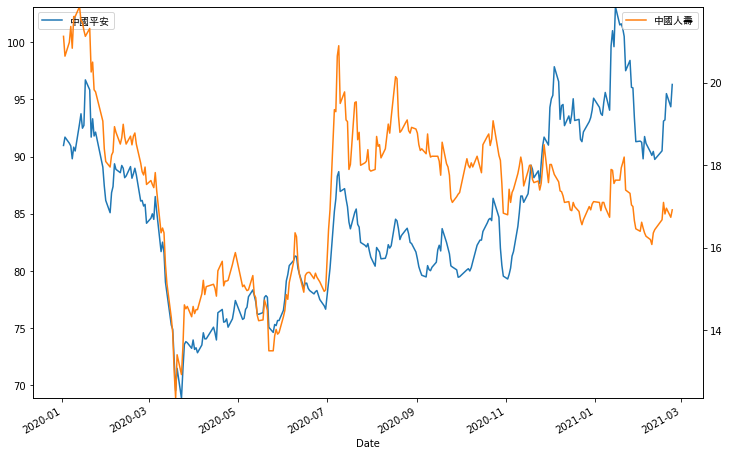

In [18]:
# Pick 2 stocks price chart to to show the price correlation
stockA = '中國平安'
stockB = '中國人壽'
plotPair(stocks, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)

In [19]:
# Run the price correlation for all stock Pair combination
# Using the the default "pearson correlatoin"

stocksCorr = stocks.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

In [20]:
# Filter the correlated stocks pair with the THRESHOLD
THRESHOLD = 0.95
highCorr = np.where(((stocksCorr >= THRESHOLD) & (stocksCorr < 1)))


#Found the price correlated pairs and store in a dataframe
pairsDf = pd.DataFrame(columns=['corr', 'stockA', 'stockB', 'sameSector', 'sectorA', 'sectorB'])
count = 0
pairs = {}

for i in range(len(highCorr[0])):
  a, b = highCorr[0][i], highCorr[1][i]
  revKey = str(b) + str(a)

  # prevent duplicated plot as (a,b) pair is the same as (b,a) pair
  if revKey not in pairs:
    # Get the sector from the Pair
    sectorA = stocksFilteredInfo.loc[stocksFilteredInfo[COL_NAME]==columnNames[a], COL_SECTOR].values[0]
    sectorB = stocksFilteredInfo.loc[stocksFilteredInfo[COL_NAME]==columnNames[b], COL_SECTOR].values[0]

    if sectorA == sectorB:
      sameSector = True
    else:
      sameSector = False

    # Construct the pair key id for comparing duplication
    key = str(a) +str(b)
    pairs[key] = [a, b]

    # Get the Pair correlation and store the details in a dataframe
    corr = round(stocksCorr.at[columnNames[a], columnNames[b]], 4)
    pairsDf.loc[count] = [corr, columnNames[a], columnNames[b], sameSector, sectorA, sectorB]
    count += 1

# shows the Pairs sorted by correlations
pairsDf = pairsDf.sort_values(by=['corr'], ascending=False)  
pairsDf      

corr   stockA   stockB sameSector  sectorA  sectorB
153  0.9957    南方A50   華夏滬深三百       True  股票 - 中國  股票 - 中國
154  0.9950    南方A50  安碩A50-R       True  股票 - 中國  股票 - 中國
152  0.9939  FL二南方恒指     盈富基金      False   指數槓桿產品  股票 - 香港
101  0.9921     信義光能    福萊特玻璃      False    光伏太陽能      玻璃股
155  0.9913   華夏滬深三百  安碩A50-R       True  股票 - 中國  股票 - 中國
..      ...      ...      ...        ...      ...      ...
121  0.9506    華虹半導體     敏華控股      False      半導體       家品
100  0.9505     信義光能     康龍化成      False    光伏太陽能     生物科技
14   0.9505    香港交易所    碧桂園服務      False   其他金融服務  物業管理及代理
30   0.9504     藥明生物      海底撈      False     生物科技       餐飲
77   0.9502     申洲國際     信義玻璃      False     紡織製衣      玻璃股

[156 rows x 6 columns]

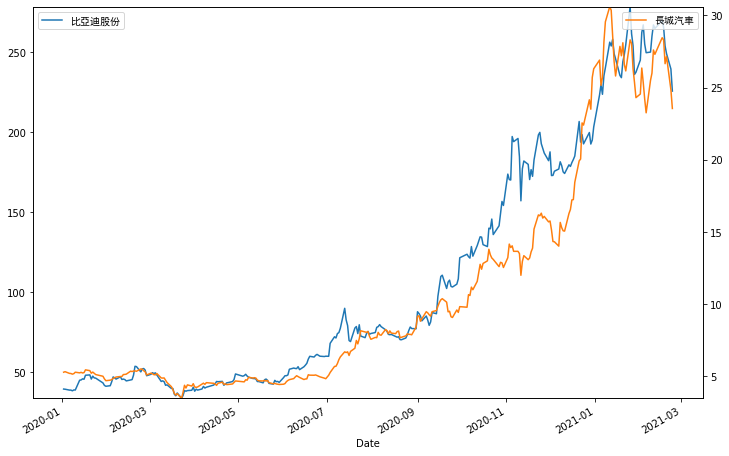

In [21]:
# Pick 2 stocks price chart to to show the price correlation
stockA = '比亞迪股份'
stockB = '長城汽車'
plotPair(stocks, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)


 153 : 南方A50 vs 華夏滬深三百 ( 0.9957 )


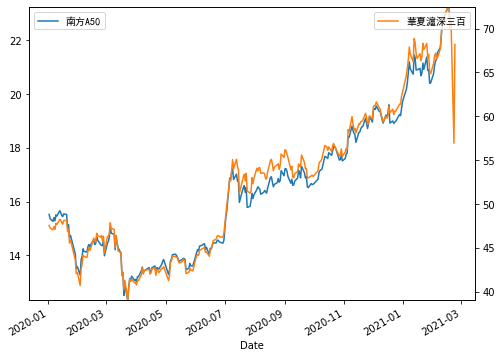


 154 : 南方A50 vs 安碩A50-R ( 0.995 )


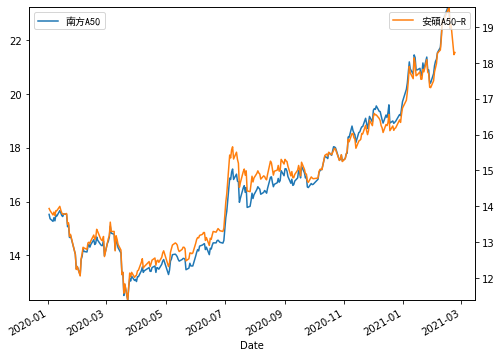


 155 : 華夏滬深三百 vs 安碩A50-R ( 0.9913 )


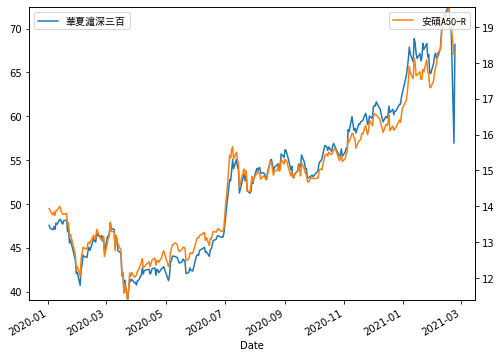


 41 : 藥明生物 vs 康龍化成 ( 0.9798 )


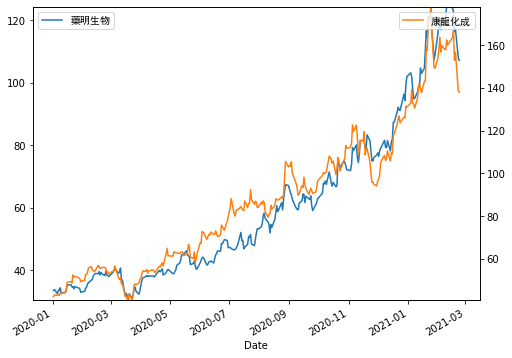


 119 : 信義玻璃 vs 福萊特玻璃 ( 0.9717 )


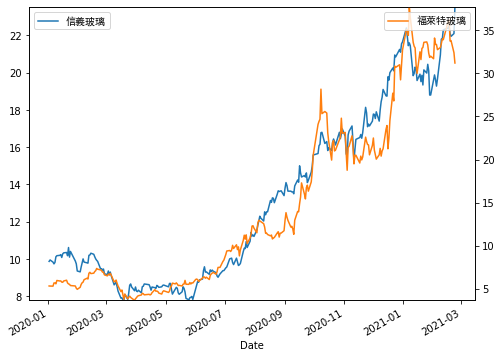


 80 : 碧桂園服務 vs 永升生活服務 ( 0.9714 )


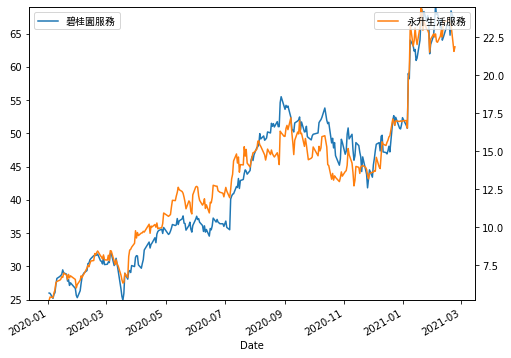


 87 : 比亞迪股份 vs 長城汽車 ( 0.9704 )


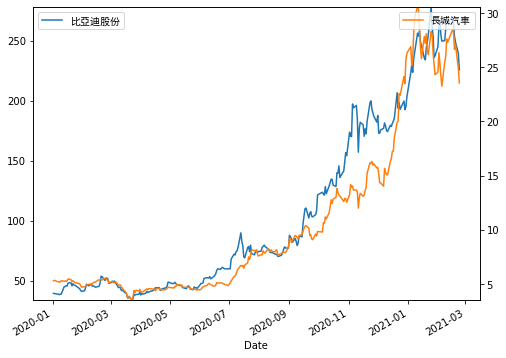


 64 : 吉利汽車 vs 長城汽車 ( 0.9641 )


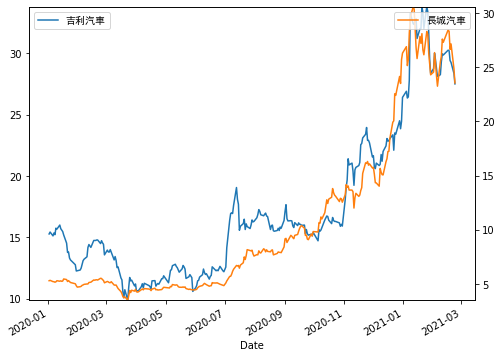


 81 : 中升控股 vs 美東汽車 ( 0.9573 )


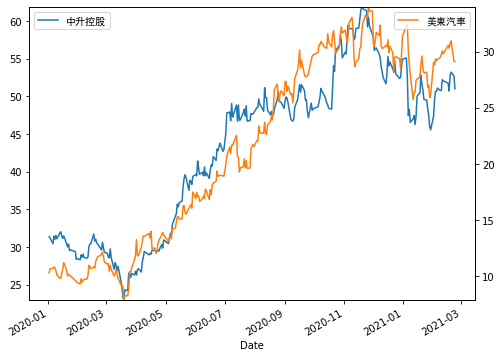


 50 : 安踏體育 vs 李寧 ( 0.9544 )


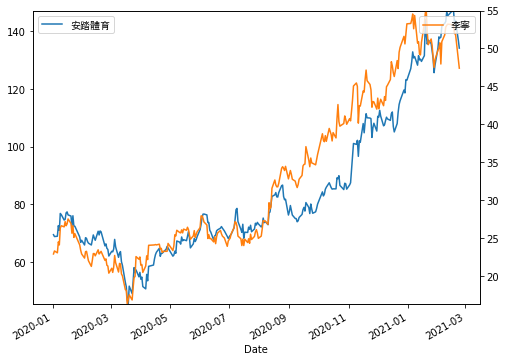

In [22]:
# Plot all the correlated Pairs with same sector
sectorPairsDf = pairsDf[(pairsDf.sameSector == True)]

for index, row in sectorPairsDf.iterrows():
    print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
    plotPair(stocks, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)

In [23]:
# Select a Pair for running the ratio
selected_pair = 87

# Calculate the stock price ratios of Pair A/B and Pair B/A over the date period
# The price ratio is "adjusted close price" ratio between the 2 stocks
PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
BA_stock = PAIR_STOCK_B + " / " + PAIR_STOCK_A

stocks[AB_stock] = stocks[PAIR_STOCK_A] / stocks[PAIR_STOCK_B]
stocks[BA_stock] = stocks[PAIR_STOCK_B] / stocks[PAIR_STOCK_A]

stocks[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock, BA_stock]]

比亞迪股份       長城汽車  比亞迪股份 / 長城汽車  長城汽車 / 比亞迪股份
Date                                                         
2020-01-02   39.307705   5.290638      7.429671      0.134595
2020-01-03   39.207813   5.326814      7.360463      0.135861
2020-01-06   38.658405   5.209245      7.421115      0.134751
2020-01-07   38.658405   5.200200      7.434023      0.134517
2020-01-08   38.208885   5.154981      7.412032      0.134916
...                ...        ...           ...           ...
2021-02-17  265.399994  28.299999      9.378092      0.106631
2021-02-18  253.800003  26.650000      9.523452      0.105004
2021-02-19  249.000000  27.150000      9.171271      0.109036
2021-02-22  239.399994  24.850000      9.633802      0.103801
2021-02-23  225.600006  23.549999      9.579618      0.104388

[283 rows x 4 columns]

In [24]:
# Calculate the average price ratio of the Pair over the period
# Trade if the current price ratio is significantly different 
PX_RATIO_THRESHOLD = 0.05

# Calculate the average Buy PAIR_STOCK_A / Sell PAIR_STOCK_B ratio
avgPxRatio = stocks[AB_stock].mean()
print("Average BUY/SELL price ratio of", AB_stock, ":", avgPxRatio)

execPxRatio = avgPxRatio * (1 - PX_RATIO_THRESHOLD)
upper_execPxRatio = avgPxRatio * (1 + PX_RATIO_THRESHOLD)
print("Buy", PAIR_STOCK_A, "and Sell", PAIR_STOCK_B, "when the BUY/SELL price ratio is smaller than:", execPxRatio)
print("Sell", PAIR_STOCK_A, "and Buy", PAIR_STOCK_B, "when the BUY/SELL price ratio is larger than:", upper_execPxRatio)

print(f'-'*100)
print("The ratio can be reached when relatively ... ")
print(PAIR_STOCK_A, "goes down and become under-valued and should buy it")
print(PAIR_STOCK_B, "goes up and become over-valued and should sell it")

Average BUY/SELL price ratio of 比亞迪股份 / 長城汽車 : 10.063191575938434
Buy 比亞迪股份 and Sell 長城汽車 when the BUY/SELL price ratio is smaller than: 9.560031997141513
Sell 比亞迪股份 and Buy 長城汽車 when the BUY/SELL price ratio is larger than: 10.566351154735356
----------------------------------------------------------------------------------------------------
The ratio can be reached when relatively ... 
比亞迪股份 goes down and become under-valued and should buy it
長城汽車 goes up and become over-valued and should sell it


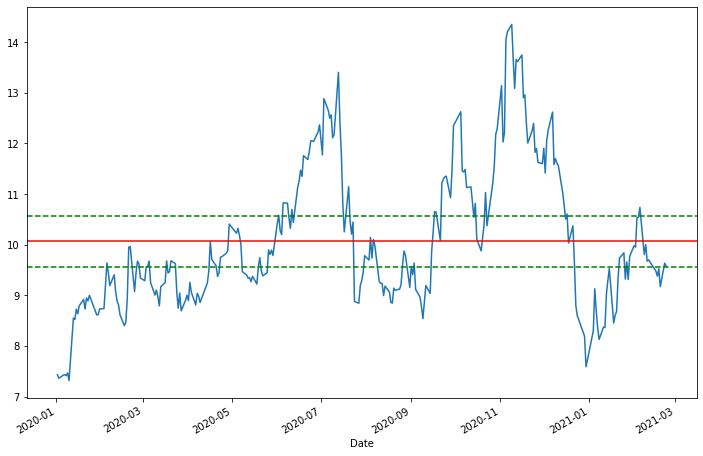

In [25]:
# Plot the averge ratio vs the price ratio threshold
stocks[AB_stock].plot(figsize=(CHART_SIZE_X, CHART_SIZE_Y))

plt.axhline(y=avgPxRatio, color='r', linestyle='-')
plt.axhline(y=execPxRatio, color='g', linestyle='--')
plt.axhline(y=upper_execPxRatio, color='g', linestyle='--')

In [27]:
stocks[AB_stock]

Date
2020-01-02    7.429671
2020-01-03    7.360463
2020-01-06    7.421115
2020-01-07    7.434023
2020-01-08    7.412032
                ...   
2021-02-17    9.378092
2021-02-18    9.523452
2021-02-19    9.171271
2021-02-22    9.633802
2021-02-23    9.579618
Name: 比亞迪股份 / 長城汽車, Length: 283, dtype: float64

In [28]:
# define input sequence and no. of features
# Use only the "close" price as the input feature
raw_seq = stocks[AB_stock].values
n_features = raw_seq.ndim
data_size = len(raw_seq)

print("n_features:", n_features) 
print("data_size:", data_size)

n_features: 1
data_size: 283


In [29]:
import datetime
import statistics as stats
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [30]:
SCREEN_X, SCREEN_Y = 12, 8

def CryptoData(symbol, frequency, start=0):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start='+str(start)
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


def getPrediction(lstm, raw_seq, index, n_steps, n_features):
  x_seq = raw_seq[index-n_steps : index]
  x_seq = x_seq.reshape(1, n_steps, n_features)
  
  yhat = lstm.predict(x_seq)
  y = raw_seq[index]
  
  return x_seq, yhat, y


# predict the next day close as the same as today's close 
def getBasePrediction(raw_seq, index, n_steps):
  x_seq = raw_seq[index-n_steps : index]
  
  yhat = x_seq[len(x_seq)-1]
  y = raw_seq[index]
  
  return x_seq, yhat, y


def roundNum(num, dp=2):
	return round(num, dp)

In [31]:
# split the data into training and test set
train_ratio = 0.8
train_size = round(train_ratio * data_size)
train_seq = raw_seq[:train_size]
test_seq = raw_seq[train_size:]

print("train_size:", train_size)
print("test_size:", data_size-train_size)

train_size: 226
test_size: 57


In [32]:
# choose a number of time steps
n_steps = 7

# split into training samples
x_train, y_train = split_sequence(train_seq, n_steps)

# reshape from [samples, timesteps] to [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], n_features)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (219, 7, 1)
y_train shape: (219,)


In [33]:
index = 0
print(x_train[index])
print('--->', y_train[index])

[[7.42967136]
 [7.36046265]
 [7.42111521]
 [7.43402267]
 [7.41203201]
 [7.46621567]
 [7.31638564]]
---> 8.55064914664338


In [34]:
index = 1
print(x_train[index])
print('--->', y_train[index])

[[7.36046265]
 [7.42111521]
 [7.43402267]
 [7.41203201]
 [7.46621567]
 [7.31638564]
 [8.55064915]]
---> 8.520452168759858


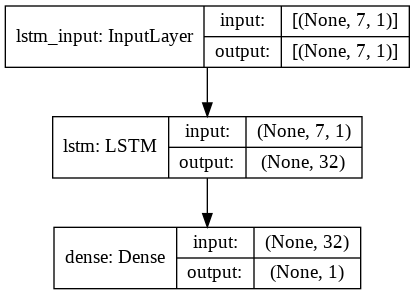

In [35]:
# define the LTSM model
# The number of hidden neurons in LSTM does not directly relate to the timestep 
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

plot_model(model, show_shapes=True, show_layer_names=True)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
7/7 [==============================] - 1s 6ms/step - loss: 78.6018
Epoch 2/50
7/7 [==============================] - 0s 4ms/step - loss: 46.1940
Epoch 3/50
7/7 [==============================] - 0s 4ms/step - loss: 16.8026
Epoch 4/50
7/7 [==============================] - 0s 4ms/step - loss: 2.6883
Epoch 5/50
7/7 [==============================] - 0s 3ms/step - loss: 4.3705
Epoch 6/50
7/7 [==============================] - 0s 4ms/step - loss: 1.2790
Epoch 7/50
7/7 [==============================] - 0s 4ms/step - loss: 1.8650
Epoch 8/50
7/7 [==============================] - 0s 3ms/step - loss: 1.1891
Epoch 9/50
7/7 [==============================] - 0s 4ms/step - loss: 1.0984
Epoch 10/50
7/7 [==============================] - 0s 4ms/step - loss: 0.8746
Epoch 11/50
7/7 [==============================] - 0s 3ms/step - loss: 0.8839
Epoch 12/50
7/7 [==============================] - 0s 3ms/step - loss: 0.6702
Epoch 13/50
7/7 [==============================] - 0s 4ms/step - loss:

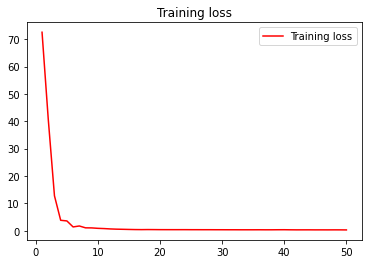

In [37]:
# fit model
history = model.fit(x_train, y_train, epochs=50)

# Plot the loss
loss = history.history['loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [38]:
# predict the next day
index = train_size
x_seq, yhat, y = getPrediction(model, raw_seq, index, n_steps, n_features)

predicted = yhat[0][0]
actual = y
error = actual - predicted
errorP = abs(error) / predicted

print(x_seq, "\n")
print("Predicted:", predicted)
print("Actual:", actual)
print("Error:", error)
print("Error%:", roundNum(errorP, 4)*100)

[[[12.0065791 ]
  [12.24969056]
  [12.39454049]
  [11.82208626]
  [11.89849583]
  [11.623134  ]
  [11.59872664]]] 

Predicted: 11.614441
Actual: 11.903553513896474
Error: 0.2891125959277243
Error%: 2.4899999999999998


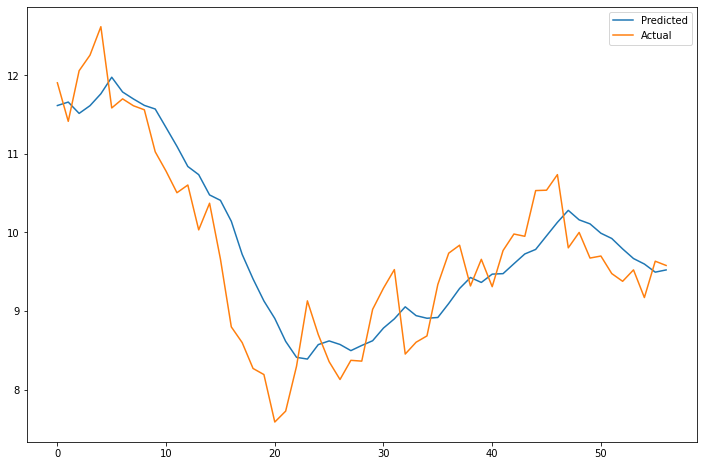

In [39]:
# Predict the rest of the series and comparing to the test set
# Each prediction is based on the "actual" observation from the past days
# Another way is to use multi-step ahead output or
# use the predicted values as new observations to further predict the rest of the series

predictedList = []
actualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getPrediction(model, raw_seq, i, n_steps, n_features)
  predictedList.append(yhat[0][0])
  actualList.append(y)

# plot the result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="Predicted")
plt.plot(actualList, label="Actual")
plt.legend()

In [40]:
# look at the individual predictions
lstmError = []
lstmErrorP = []
for i in range(len(predictedList)):
  error = actualList[i]-predictedList[i]
  absError = abs(error)
  errorP = absError/actualList[i]
  lstmError.append(absError)
  lstmErrorP.append(errorP)

  print("Predicted:", roundNum(predictedList[i]),
       "  Actual:", roundNum(actualList[i]),
       "  Error:", roundNum(error), 
        "->", roundNum(errorP), sep='')

print("--------------------------------------")  
print("Error: Total=",roundNum(sum(lstmError)), " Average=",roundNum(stats.mean(lstmError)), " Min=",roundNum(min(lstmError)), " Max=",roundNum(max(lstmError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(lstmErrorP)), " Min=",roundNum(min(lstmErrorP)), " Max=",roundNum(max(lstmErrorP)), sep='')

Predicted:11.61  Actual:11.9  Error:0.29->0.02
Predicted:11.66  Actual:11.41  Error:-0.24->0.02
Predicted:11.51  Actual:12.06  Error:0.54->0.05
Predicted:11.61  Actual:12.26  Error:0.64->0.05
Predicted:11.76  Actual:12.62  Error:0.85->0.07
Predicted:11.97  Actual:11.58  Error:-0.39->0.03
Predicted:11.79  Actual:11.7  Error:-0.09->0.01
Predicted:11.7  Actual:11.61  Error:-0.09->0.01
Predicted:11.62  Actual:11.56  Error:-0.06->0.0
Predicted:11.57  Actual:11.03  Error:-0.54->0.05
Predicted:11.33  Actual:10.78  Error:-0.55->0.05
Predicted:11.1  Actual:10.51  Error:-0.59->0.06
Predicted:10.84  Actual:10.6  Error:-0.24->0.02
Predicted:10.74  Actual:10.03  Error:-0.7->0.07
Predicted:10.48  Actual:10.37  Error:-0.11->0.01
Predicted:10.41  Actual:9.66  Error:-0.75->0.08
Predicted:10.14  Actual:8.8  Error:-1.34->0.15
Predicted:9.72  Actual:8.6  Error:-1.12->0.13
Predicted:9.41  Actual:8.27  Error:-1.14->0.14
Predicted:9.13  Actual:8.19  Error:-0.94->0.11
Predicted:8.91  Actual:7.59  Error:-1.32-

In [41]:
# Baseline comparison: predict the next day price ratio as the same as today's price ratio
basePredictedList = []
baseActualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getBasePrediction(raw_seq, i, n_steps)
  basePredictedList.append(yhat)
  baseActualList.append(y)


# look at the individual predictions
baseError = []
baseErrorP = []
for i in range(len(basePredictedList)):
  error = baseActualList[i]-basePredictedList[i]
  absError = abs(error)
  errorP = absError/baseActualList[i]
  baseError.append(absError)
  baseErrorP.append(errorP)

  print("Predicted:", roundNum(basePredictedList[i]),
       "  Actual:", roundNum(baseActualList[i]),
       "  Error:", roundNum(error), 
        "->", roundNum(errorP), sep='')

print("--------------------------------------")  
print("Error: Total=",roundNum(sum(baseError)), " Average=",roundNum(stats.mean(baseError)), " Min=",roundNum(min(baseError)), " Max=",roundNum(max(baseError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(baseErrorP)), " Min=",roundNum(min(baseErrorP)), " Max=",roundNum(max(baseErrorP)), sep='')

Predicted:11.6  Actual:11.9  Error:0.3->0.03
Predicted:11.9  Actual:11.41  Error:-0.49->0.04
Predicted:11.41  Actual:12.06  Error:0.64->0.05
Predicted:12.06  Actual:12.26  Error:0.2->0.02
Predicted:12.26  Actual:12.62  Error:0.36->0.03
Predicted:12.62  Actual:11.58  Error:-1.03->0.09
Predicted:11.58  Actual:11.7  Error:0.12->0.01
Predicted:11.7  Actual:11.61  Error:-0.09->0.01
Predicted:11.61  Actual:11.56  Error:-0.05->0.0
Predicted:11.56  Actual:11.03  Error:-0.53->0.05
Predicted:11.03  Actual:10.78  Error:-0.25->0.02
Predicted:10.78  Actual:10.51  Error:-0.27->0.03
Predicted:10.51  Actual:10.6  Error:0.1->0.01
Predicted:10.6  Actual:10.03  Error:-0.57->0.06
Predicted:10.03  Actual:10.37  Error:0.34->0.03
Predicted:10.37  Actual:9.66  Error:-0.71->0.07
Predicted:9.66  Actual:8.8  Error:-0.86->0.1
Predicted:8.8  Actual:8.6  Error:-0.2->0.02
Predicted:8.6  Actual:8.27  Error:-0.33->0.04
Predicted:8.27  Actual:8.19  Error:-0.08->0.01
Predicted:8.19  Actual:7.59  Error:-0.6->0.08
Predict

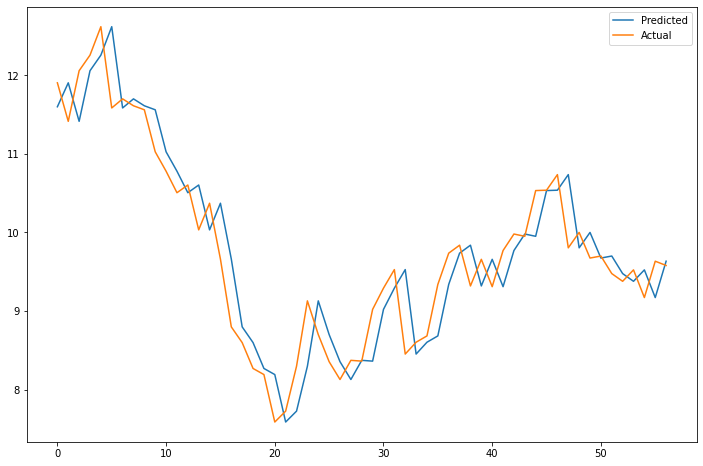

In [42]:
# plot base result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(basePredictedList, label="Predicted")
plt.plot(baseActualList, label="Actual")
plt.legend()

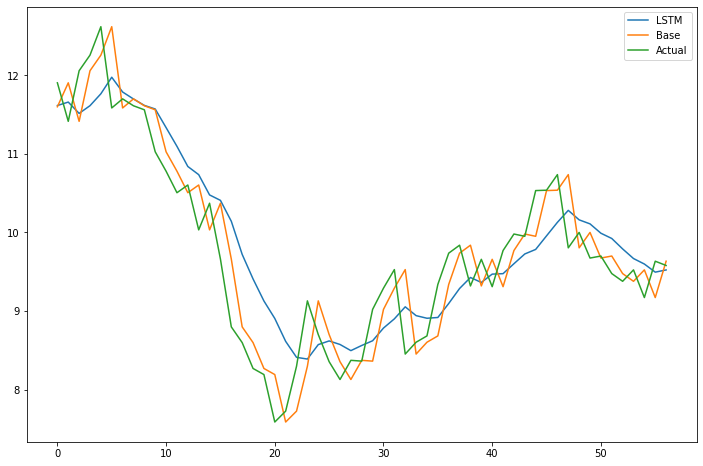

In [43]:
# plot all results
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="LSTM")
plt.plot(basePredictedList, label="Base")
plt.plot(baseActualList, label="Actual")
plt.legend()

In [44]:
df=stocks[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock, BA_stock]]
df

比亞迪股份       長城汽車  比亞迪股份 / 長城汽車  長城汽車 / 比亞迪股份
Date                                                         
2020-01-02   39.307705   5.290638      7.429671      0.134595
2020-01-03   39.207813   5.326814      7.360463      0.135861
2020-01-06   38.658405   5.209245      7.421115      0.134751
2020-01-07   38.658405   5.200200      7.434023      0.134517
2020-01-08   38.208885   5.154981      7.412032      0.134916
...                ...        ...           ...           ...
2021-02-17  265.399994  28.299999      9.378092      0.106631
2021-02-18  253.800003  26.650000      9.523452      0.105004
2021-02-19  249.000000  27.150000      9.171271      0.109036
2021-02-22  239.399994  24.850000      9.633802      0.103801
2021-02-23  225.600006  23.549999      9.579618      0.104388

[283 rows x 4 columns]

In [49]:
"""

Signal (1, -1)
   1 Buy stock A and Sell stock B
  -1 Buy stock B and Sell stock A
  0 Flat

"""

def test_ma(df):
    ma_df = df.copy()
    

    # Remove the NaN rows
    ma_df.dropna(inplace = True)


    # signal column will govern the buying and selling logic as described above; 

    ma_df['signal'] = np.where(ma_df['比亞迪股份 / 長城汽車'] < execPxRatio, 1,0)
    ma_df['signal'] = np.where(ma_df['比亞迪股份 / 長城汽車'] > upper_execPxRatio, -1,ma_df['signal'])
    # Market column as log returns of price series - which is the market performance
    ma_df['Market1'] = np.log(ma_df['比亞迪股份'] / ma_df['比亞迪股份'].shift(1))
    ma_df['Market2'] = np.log(ma_df['長城汽車'] / ma_df['長城汽車'].shift(1))
    
    # compute our Strategy returns by multiplying signal (shifted forward to match the Market column
    ma_df['Strategy'] = ma_df['signal'].shift(1) * ma_df['Market1']-ma_df['signal'].shift(1) * ma_df['Market2']
    
    # perform a cumulative sum operation as well as apply an exponent on Market and Strategy log returns 
    # in order to recover the original normalised series
    ma_df[['Market1','Market2','Strategy']] = ma_df[['Market1','Market2','Strategy']].cumsum().apply(np.exp)
    return ma_df

In [50]:
ma_df = test_ma(df).dropna()

Trade_COLUMNS = ['比亞迪股份', '長城汽車', '比亞迪股份 / 長城汽車', 'signal', 'Market1', 'Market2','Strategy']
ma_df[Trade_COLUMNS]

比亞迪股份       長城汽車  比亞迪股份 / 長城汽車  ...   Market1   Market2  Strategy
Date                                             ...                              
2020-01-03   39.207813   5.326814      7.360463  ...  0.997459  1.006838  0.990685
2020-01-06   38.658405   5.209245      7.421115  ...  0.983482  0.984616  0.998848
2020-01-07   38.658405   5.200200      7.434023  ...  0.983482  0.982906  1.000586
2020-01-08   38.208885   5.154981      7.412032  ...  0.972046  0.974359  0.997626
2020-01-09   38.758293   5.191156      7.466216  ...  0.986023  0.981197  1.004919
...                ...        ...           ...  ...       ...       ...       ...
2021-02-17  265.399994  28.299999      9.378092  ...  6.751857  5.349071  6.079966
2021-02-18  253.800003  26.650000      9.523452  ...  6.456749  5.037199  6.174206
2021-02-19  249.000000  27.150000      9.171271  ...  6.334636  5.131706  5.945881
2021-02-22  239.399994  24.850000      9.633802  ...  6.090409  4.696976  6.245747
2021-02-23  225.600006  23.549999      9.579618  ...  5.739333  4.451258  6.245747

[282 rows x 7 columns]

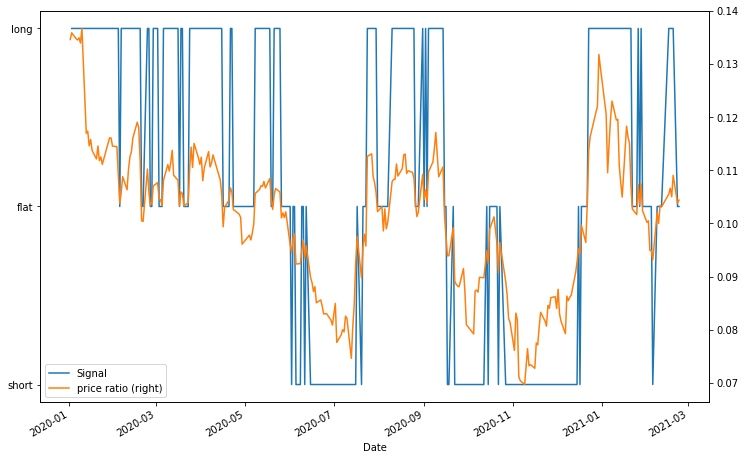

In [56]:
# Plot signal

ax1 = ma_df.signal.plot(label='Signal', legend=True, figsize=(SCREEN_X, SCREEN_Y))
ax1.set_ylim(-1.1, 1.1)
plt.yticks([-1, 0, 1], ['sell A buy B', 'No action', 'buy A sell B'])

ax2 = df['長城汽車 / 比亞迪股份'].plot(secondary_y=True, label='price ratio', legend=True, figsize=(SCREEN_X, SCREEN_Y))


In [52]:
# Market: buy_and_hold strategy
# Strategy: pair trading

ma_df[['Market1','Market2', 'Strategy']].iloc[-1]

Market1     5.739333
Market2     4.451258
Strategy    6.245747
Name: 2021-02-23 00:00:00, dtype: float64